In [26]:
import os
import gzip
import struct
import numpy as np
from torch.utils.data import Dataset

_DTYPE_MAP = {
    0x08: np.uint8,
    0x09: np.int8,
    0x0B: np.int16,
    0x0C: np.int32,
    0x0D: np.float32,
    0x0E: np.float64,
}

def read_idx(path):
    """Read an IDX file (optionally .gz) and return a NumPy array."""
    opener = gzip.open if path.endswith('.gz') else open
    with opener(path, 'rb') as f:
        _, _, dtype_code, ndim = struct.unpack('>BBBB', f.read(4))
        shape = struct.unpack('>' + 'I' * ndim, f.read(4 * ndim))
        data = np.frombuffer(f.read(), dtype=_DTYPE_MAP[dtype_code])
        return data.reshape(shape)

class MNISTNumberDataset(Dataset):
    def __init__(self, root, num=1, train=True, return_numpy=True):
        """
        root: folder with MNIST files
        num: digit to keep (0–9)
        train: use training or test set
        return_numpy: if True, returns NumPy arrays; if False, torch tensors
        """
        self.num = num
        self.return_numpy = return_numpy

        # pick files
        if train:
            img_file = os.path.join(root, "train-images-idx3-ubyte.gz")
            lbl_file = os.path.join(root, "train-labels-idx1-ubyte.gz")
        else:
            img_file = os.path.join(root, "t10k-images-idx3-ubyte.gz")
            lbl_file = os.path.join(root, "t10k-labels-idx1-ubyte.gz")
        if not os.path.exists(img_file): img_file = img_file[:-3]
        if not os.path.exists(lbl_file): lbl_file = lbl_file[:-3]

        images = read_idx(img_file)   # (N, 28, 28)
        labels = read_idx(lbl_file)   # (N,)

        # keep only the chosen number
        mask = labels == num
        self.images = images[mask]

        self._torch = None  # lazy torch import

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.return_numpy:
            return img
        else:
            if self._torch is None:
                import torch
                self._torch = torch
            return self._torch.from_numpy(img.astype(np.float32) / 255.0).unsqueeze(0)

ds = MNISTNumberDataset(
    root="/home/data1/musong/workspace/python/2026-CVPR/my-repo/data/mnist",
    num=1,
    train=True,
    return_numpy=True
)


In [30]:
# ===== data: wrap your MNISTNumberDataset to make (LR, HR) pairs =====
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class PairDownsample2x(Dataset):
    """Wraps a dataset that returns single images (numpy uint8 HxW or torch 1xHxW).
       Returns (LR_up_to_28, HR) as float tensors in [0,1], both shaped (1,28,28)."""
    def __init__(self, base_ds):
        self.base = base_ds

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img = self.base[idx]  # (H,W) numpy uint8 or torch tensor, or (1,H,W) torch

        # to torch float in [0,1]
        if not torch.is_tensor(img):
            img = torch.from_numpy(img)
        img = img.float()
        if img.max() > 1.0:  # handle uint8 -> float case
            img = img / 255.0

        # ensure C,H,W with C=1
        if img.dim() == 2:
            img = img.unsqueeze(0)          # (1,28,28)
        elif img.dim() == 3 and img.shape[0] != 1:
            raise ValueError(f"Expected single-channel image, got shape {tuple(img.shape)}")

        # add batch once -> (N=1,C=1,H,W)
        x = img.unsqueeze(0)                 # (1,1,28,28)

        # downsample to 14x14 then upsample back to 28x28
        lr = F.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)          # (1,1,14,14)
        lr_up = F.interpolate(lr, size=(28, 28), mode="bilinear", align_corners=False)         # (1,1,28,28)

        # return without batch dim
        return lr_up.squeeze(0), x.squeeze(0)  # both (1,28,28)
    
# use your dataset, but return tensors so DataLoader plays nice
train_base = MNISTNumberDataset(
    root="/home/data1/musong/workspace/python/2026-CVPR/my-repo/data/mnist",
    num=1, train=True, return_numpy=False
)
test_base = MNISTNumberDataset(
    root="/home/data1/musong/workspace/python/2026-CVPR/my-repo/data/mnist",
    num=2, train=False, return_numpy=False
)

train_ds = PairDownsample2x(train_base)
test_ds  = PairDownsample2x(test_base)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# ===== a tiny autoencoder for reconstruction =====
import torch.nn as nn

class TinyAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 14x14
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 7x7
            nn.ReLU(inplace=True),
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1), # 14x14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),  # 28x28
            nn.Sigmoid()
        )
    def forward(self, x):
        z = self.enc(x)
        return self.dec(z)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyAE().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
crit  = nn.L1Loss()

# ===== train (on digit 1 LR->HR) =====
for epoch in range(20):
    model.train()
    running = 0.0
    for x_lr, x_hr in train_loader:
        x_lr, x_hr = x_lr.to(device), x_hr.to(device)
        pred = model(x_lr)
        loss = crit(pred, x_hr)
        optim.zero_grad(); loss.backward(); optim.step()
        running += loss.item() * x_lr.size(0)
    print(f"epoch {epoch+1}: train L1 = {running/len(train_loader.dataset):.4f}")

# ===== evaluate (on digit 2 LR->HR) =====
model.eval()
test_loss = 0.0
with torch.no_grad():
    for x_lr, x_hr in test_loader:
        x_lr, x_hr = x_lr.to(device), x_hr.to(device)
        pred = model(x_lr)
        test_loss += crit(pred, x_hr).item() * x_lr.size(0)
print(f"test L1 on digit-2: {test_loss/len(test_loader.dataset):.4f}")


epoch 1: train L1 = 0.3139
epoch 2: train L1 = 0.0834
epoch 3: train L1 = 0.0778
epoch 4: train L1 = 0.0769
epoch 5: train L1 = 0.0765
epoch 6: train L1 = 0.0764
epoch 7: train L1 = 0.0763
epoch 8: train L1 = 0.0762
epoch 9: train L1 = 0.0762
epoch 10: train L1 = 0.0761
epoch 11: train L1 = 0.0761
epoch 12: train L1 = 0.0761
epoch 13: train L1 = 0.0761
epoch 14: train L1 = 0.0760
epoch 15: train L1 = 0.0760
epoch 16: train L1 = 0.0760
epoch 17: train L1 = 0.0760
epoch 18: train L1 = 0.0760
epoch 19: train L1 = 0.0760
epoch 20: train L1 = 0.0760
test L1 on digit-2: 0.1502


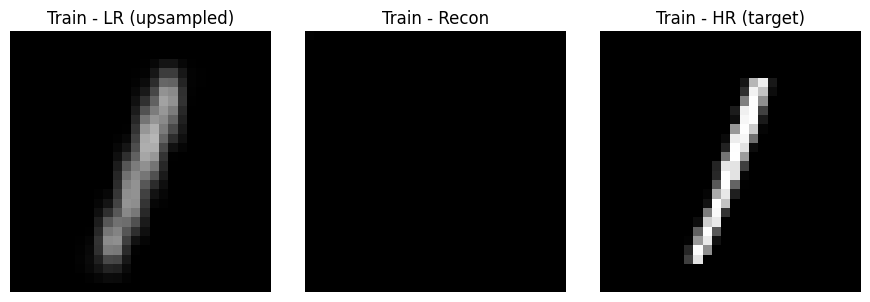

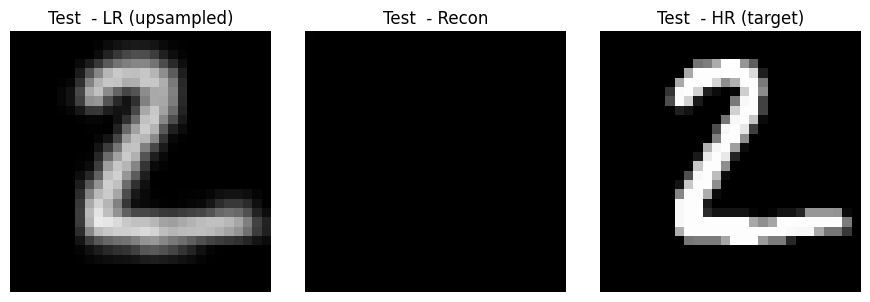

[Train 1s] PSNR: 12.22 dB | SSIM: 0.4913
[Test  2s] PSNR: 9.64 dB | SSIM: 0.1806


In [31]:
import torch
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# ---- helper: run model forward on a single (lr, hr) pair ----
def forward_one(model, pair):
    x_lr, x_hr = pair
    with torch.no_grad():
        pred = model(x_lr.unsqueeze(0).to(device))  # (1,1,28,28)
    return x_lr.squeeze(0).cpu(), pred.squeeze(0).cpu(), x_hr.squeeze(0).cpu()

# ---- 1) plot one train example and one test example ----
model.eval()

# grab one from train
train_sample = next(iter(train_loader))
x_lr_b, x_hr_b = train_sample[0], train_sample[1]        # (B,1,28,28)
x_lr, recon, x_hr = forward_one(model, (x_lr_b[0], x_hr_b[0]))

# grab one from test
test_sample = next(iter(test_loader))
x_lr_b_t, x_hr_b_t = test_sample[0], test_sample[1]
x_lr_t, recon_t, x_hr_t = forward_one(model, (x_lr_b_t[0], x_hr_b_t[0]))

def imshow_triplet(lr, rec, hr, title_prefix=""):
    """lr/rec/hr are (1,28,28) torch tensors in [0,1]"""
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    for ax, im, tt in zip(axes, [lr, rec, hr], ["LR (upsampled)", "Recon", "HR (target)"]):
        ax.imshow(im.squeeze(0).numpy(), cmap="gray", vmin=0.0, vmax=1.0)
        ax.set_title(f"{title_prefix}{tt}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

imshow_triplet(x_lr,  recon,  x_hr,  title_prefix="Train - ")
imshow_triplet(x_lr_t, recon_t, x_hr_t, title_prefix="Test  - ")

# ---- 2) compute PSNR / SSIM over 100 samples for train and test ----
def evaluate_psnr_ssim(model, loader, max_samples=100):
    model.eval()
    n = 0
    psnr_sum = 0.0
    ssim_sum = 0.0
    with torch.no_grad():
        for x_lr_b, x_hr_b in loader:
            # forward
            pred_b = model(x_lr_b.to(device)).cpu()   # (B,1,28,28)
            x_hr_b = x_hr_b.cpu()
            bsz = x_lr_b.size(0)
            for i in range(bsz):
                rec = pred_b[i, 0].numpy()  # (28,28), [0,1]
                hr  = x_hr_b[i, 0].numpy()  # (28,28), [0,1]

                psnr_sum += psnr(hr, rec, data_range=1.0)
                ssim_sum += ssim(hr, rec, data_range=1.0)
                n += 1
                if n >= max_samples:
                    break
            if n >= max_samples:
                break
    return psnr_sum / n, ssim_sum / n

train_psnr, train_ssim = evaluate_psnr_ssim(model, train_loader, max_samples=100)
test_psnr,  test_ssim  = evaluate_psnr_ssim(model, test_loader,  max_samples=100)

print(f"[Train 1s] PSNR: {train_psnr:.2f} dB | SSIM: {train_ssim:.4f}")
print(f"[Test  2s] PSNR: {test_psnr:.2f} dB | SSIM: {test_ssim:.4f}")
